In [ ]:
!pip install --quiet wget pyunpack

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, Subset
import numpy as np
import torch.optim as optim
import os
import time
import sys
import wget
import pyunpack
import importlib
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
sys.path.append('/content/drive/MyDrive/IP/Repos/HFTransformer/Temporal_Fusion_Transform')
import tft_model
from data_formatters import ts_dataset  
import expt_settings.configs
from data_formatters import utils

In [ ]:
importlib.reload(tft_model)
importlib.reload(utils)

<module 'data_formatters.utils' from '/content/drive/MyDrive/IP/Repos/HFTransformer/Temporal_Fusion_Transform/data_formatters/utils.py'>

In [ ]:
def augment_trade_data(df, lag):
    col_name = 'target'
    # df[col_name] = np.log(df.w_midprice) - np.log(df.w_midprice).shift(lag)
    df[col_name] = df.w_midprice #np.log(df.w_midprice)
    df['log_lag10_returns'] = df.w_midprice.shift(lag+10)# np.log(df.w_midprice) - np.log(df.w_midprice).shift(lag+10)
    df['log_lag20_returns'] = df.w_midprice.shift(lag+20)# np.log(df.w_midprice) - np.log(df.w_midprice).shift(lag+20)
    df['log_lag30_returns'] = df.w_midprice.shift(lag+30)# np.log(df.w_midprice) - np.log(df.w_midprice).shift(lag+30)
    df['log_lag40_returns'] = df.w_midprice.shift(lag+40)# np.log(df.w_midprice) - np.log(df.w_midprice).shift(lag+40)
    df['log_lag50_returns'] = df.w_midprice.shift(lag+50)# np.log(df.w_midprice) - np.log(df.w_midprice).shift(lag+50)
    return df.iloc[lag+50:,:]

In [ ]:
ExperimentConfig = expt_settings.configs.ExperimentConfig

config = ExperimentConfig('orderbook', 'outputs')
data_formatter = config.make_data_formatter()

date_train = 'all' 

data_csv_path = '/content/drive/MyDrive/IP/Repos/HFTransformer/input_data/'+date_train+'/orderbook.csv'
print("Loading & splitting data...")
raw_data = pd.read_csv(data_csv_path, index_col=0)

raw_data = raw_data[2_000_000:2_100_000]

raw_data['symbol'] = 1
raw_data['datetime'] = raw_data.index
raw_data['datetime'] = pd.to_datetime(raw_data['datetime'], format='%Y-%m-%d %H:%M:%S.%f')
raw_data['exchange'] = 1
raw_data.index = [i for i in range(len(raw_data))]

raw_data = augment_trade_data(raw_data, lag=30)

train, valid, test = data_formatter.split_data(raw_data)

# Sets up default params
fixed_params = data_formatter.get_experiment_params()
params = data_formatter.get_default_model_params()

Loading & splitting data...
Formatting train-valid-test splits.
Setting scalers with training data...


In [ ]:
id_col = 'symbol'
time_col='datetime'
static_cols = ['symbol']
input_cols =['target',
             'bid1', 'bidqty1', 'bid2', 'bidqty2', 'bid3', 'bidqty3', 'bid4', 'bidqty4', 'bid5', 'bidqty5',
             'bid6', 'bidqty6', 'bid7', 'bidqty7', 'bid8', 'bidqty8', 'bid9', 'bidqty9', 'bid10', 'bidqty10',
             'ask1', 'askqty1', 'ask2', 'askqty2', 'ask3', 'askqty3', 'ask4', 'askqty4', 'ask5', 'askqty5',
             'ask6', 'askqty6', 'ask7', 'askqty7', 'ask8', 'askqty8', 'ask9', 'askqty9', 'ask10', 'askqty10',
             'log_lag10_returns','log_lag20_returns', 'log_lag30_returns','log_lag40_returns','log_lag50_returns', 'symbol', 'exchange']
target_col = 'target'

batch_size=256

time_steps = 130
num_encoder_steps = 100
samples_train = 70000 # len(train)-time_steps
samples_valid = 10000 #len(valid)-time_steps
samples_test = 1500 #len(test)-time_steps
output_size = 1
input_size = len(input_cols)
num_static = len(static_cols)

train_loader = DataLoader(
            ts_dataset.TSDataset(id_col, static_cols, time_col, input_cols,
            target_col, time_steps, samples_train,
            input_size, num_encoder_steps,num_static,
            output_size, random=False, data=train),
            batch_size=batch_size,
            num_workers=2,
            shuffle=False,
            drop_last=True)

val_loader = DataLoader(
            ts_dataset.TSDataset(id_col, static_cols, time_col, input_cols,
            target_col, time_steps, samples_valid,
            input_size, num_encoder_steps,num_static,
            output_size, random=False, data=valid),
            batch_size=batch_size,
            num_workers=2,
            shuffle=False,
            drop_last=True)

test_loader = DataLoader(
            ts_dataset.TSDataset(id_col, static_cols, time_col, input_cols,
            target_col, time_steps, samples_test,
            input_size, num_encoder_steps,num_static,
            output_size, random=False, data=test),
            batch_size=batch_size,
            num_workers=2,
            shuffle=False,
            drop_last=True)

Getting valid sampling locations.
Extracting 70000 samples...
10000 of 70000 samples done...
20000 of 70000 samples done...
30000 of 70000 samples done...
40000 of 70000 samples done...
50000 of 70000 samples done...
60000 of 70000 samples done...
70000 of 70000 samples done...
Getting valid sampling locations.
Extracting 10000 samples...
10000 of 10000 samples done...
Getting valid sampling locations.
Max samples=1500 exceeds # available segments=371


In [ ]:
static_cols = ['exchange']
categorical_cols = ['symbol']
real_cols = ['target',
             'bid1', 'bidqty1', 'bid2', 'bidqty2', 'bid3', 'bidqty3', 'bid4', 'bidqty4', 'bid5', 'bidqty5',
             'bid6', 'bidqty6', 'bid7', 'bidqty7', 'bid8', 'bidqty8', 'bid9', 'bidqty9', 'bid10', 'bidqty10',
             'ask1', 'askqty1', 'ask2', 'askqty2', 'ask3', 'askqty3', 'ask4', 'askqty4', 'ask5', 'askqty5',
             'ask6', 'askqty6', 'ask7', 'askqty7', 'ask8', 'askqty8', 'ask9', 'askqty9', 'ask10', 'askqty10',
             'returns_lag10','returns_lag20','returns_lag30','returns_lag40', 'returns_lag50']
config = {}
config['static_variables'] = len(static_cols)
config['time_varying_categoical_variables'] = 1
config['time_varying_real_variables_encoder'] = 14+32 
config['time_varying_real_variables_decoder'] = 6
config['num_masked_series'] = 7+32
config['static_embedding_vocab_sizes'] = [180]
config['time_varying_embedding_vocab_sizes'] = [180]
config['embedding_dim'] = 12
config['lstm_hidden_dimension'] = 120
config['lstm_layers'] = 1
config['dropout'] = 0.2
config['device'] = 'cuda'
config['batch_size'] = batch_size
config['encode_length'] = 100
config['attn_heads'] = 6
config['num_quantiles'] = 3
config['vailid_quantiles'] = [0.1,0.5,0.9]
config['seq_length']=130
plot_prediction = True

In [ ]:
def r_square(true, pred, train):
    repeats = len(true[0])
    train_mean = np.mean(train, axis=1).reshape(-1,1).repeat(repeats=repeats, axis=1)
    r2 = 1 - np.sum(np.square(true-pred))/np.sum(np.square(true-train_mean))
    return r2

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/content/drive/MyDrive/IP/Repos/HFTransformer/Temporal_Fusion_Transform/tft_model.py:165: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sparse_weights = self.softmax(sparse_weights).unsqueeze(2)


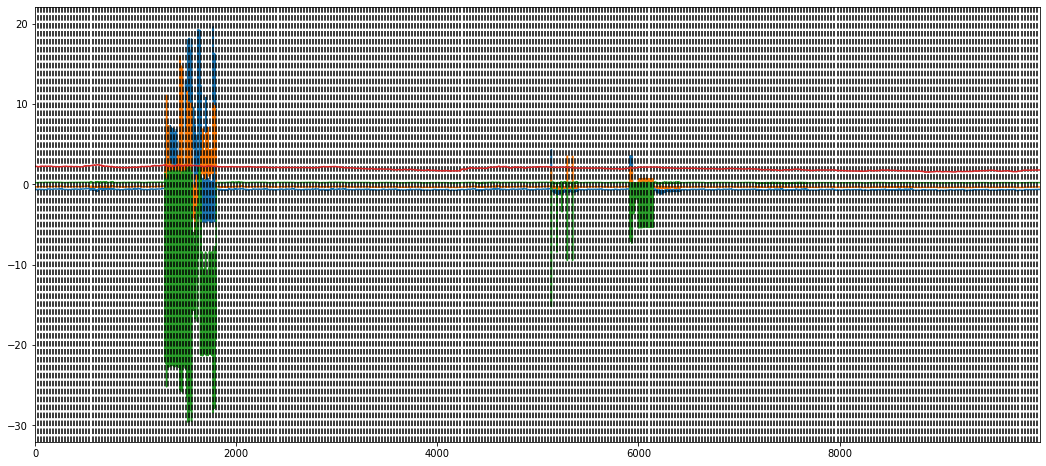

----------------------------------------------------------------------------------------
| epoch   0 | 117.26 s | training loss 0.65528 | validation loss 3.57085 | lr 0.00050000 | r2 sklearn val: -115.43963|
----------------------------------------------------------------------------------------


/content/drive/MyDrive/IP/Repos/HFTransformer/Temporal_Fusion_Transform/tft_model.py:165: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sparse_weights = self.softmax(sparse_weights).unsqueeze(2)


KeyboardInterrupt: ignored

In [ ]:
model = tft_model.TFT(config)

q_loss_func = tft_model.QuantileLoss([0.1,0.5,0.9]).to('cuda')

optimizer = optim.AdamW(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

epochs=15
forecast_horizon = time_steps - num_encoder_steps
losses = np.zeros((epochs,2))
start_time = time.time()

for epoch in range(epochs):
    train_loss, valid_loss = [], []
    outputs = torch.Tensor(0)
    targets = torch.Tensor(0)
    src_all = torch.Tensor(0)
    src = torch.Tensor(0)
    
    model.train()
    for batch in train_loader:
        output, encoder_ouput, decoder_output, attn, attn_weights, encoder_sparse_weights, decoder_sparse_weights = model(batch)
        loss = q_loss_func(output[:,:,:].view(-1,3), batch['outputs'][:,:,0].flatten().float().to('cuda'))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.05)
        optimizer.step()
        train_loss.append(loss.item())
    
    model.eval()
    for batch in val_loader:
        with torch.no_grad():
            output, encoder_ouput, decoder_output, attn, attn_weights, encoder_sparse_weights, decoder_sparse_weights = model(batch)
            loss = q_loss_func(output[:,:,:].view(-1,3), batch['outputs'][:,:,0].flatten().float().to('cuda'))
            
            target = batch
            outputs = torch.cat((outputs, output.cpu()))
            targets = torch.cat((targets,batch['outputs'][:,:,0]))
            src = torch.cat((src,batch['inputs'][:,:,:0]))
            src_all = torch.cat((src_all,batch['inputs'][:,:,:]))
            valid_loss.append(loss.item())
    
    r2_sklearn = r2_score(targets.numpy(), outputs[:,:,1].numpy())
    
    if plot_prediction:
        outputs_to_plot = torch.Tensor(0)
        targets_to_plot = torch.Tensor(0)
        losses[epoch,0], losses[epoch,1] = np.mean(train_loss), np.mean(valid_loss)

        for idx in range(len(targets)):
            if idx % forecast_horizon == 0:
                outputs_to_plot = torch.cat((outputs_to_plot, outputs[idx]))
                targets_to_plot = torch.cat((targets_to_plot, targets[idx]))
        
        fig, ax = plt.subplots(1, 1, figsize = (18, 8))
        ax.plot(outputs_to_plot[:,0].detach().cpu().numpy(), label='pred_1')
        ax.plot(outputs_to_plot[:,1].detach().cpu().numpy(), label='pred_5')
        ax.plot(outputs_to_plot[:,2].detach().cpu().numpy(), label='pred_9')
        ax.set_xlim(left=0, right=len(targets_to_plot))
        xposition = [forecast_horizon * i for i in range(1,len(outputs_to_plot)//forecast_horizon)]
        for xc in xposition:
            ax.axvline(x=xc, color='k', linestyle='--')
        ax.plot(targets_to_plot[:], label='true')

        plt.show()

    elapsed = time.time() - start_time
    print('-' * 88)
    print('| epoch {:3d} | {:5.2f} s | training loss {:5.5f} | validation loss {:5.5f} | lr {:1.8f} | r2 sklearn val: {:1.5f}|'.format(
                        epoch, elapsed, np.mean(train_loss), np.mean(valid_loss), scheduler.get_last_lr()[0], r2_sklearn))
    print('-' * 88)
    start_time = time.time()

    scheduler.step()

In [ ]:
lag = 10

for lag in range(0,30):
    target_returns = []
    pred_returns = []
    for idx in range(len(src_all)):
        src_all_denorm = data_formatter._real_scalers.inverse_transform(src_all[idx,:,:-2])
        pt = src_all_denorm[99,0]
        targets_denorm = data_formatter._target_scaler.inverse_transform(targets[idx].reshape(-1,1))
        pt_targ_n = targets_denorm[lag]
        preds_denorm = data_formatter._target_scaler.inverse_transform(outputs[idx].reshape(-1,1))
        pt_pred_n = preds_denorm[lag]
        target_returns.append(np.log(pt_targ_n/pt))
        pred_returns.append(np.log(pt_pred_n/pt))
    print(f'lag {lag+1} {r2_score(target_returns,pred_returns)}, pt_targ {pt_targ_n} pt_pred {pt_pred_n}')

lag 1 -200080.0503802707, pt_targ [22809.72638844] pt_pred [21938.98721345]
lag 2 -65761.51109080866, pt_targ [22809.72658895] pt_pred [22055.79758408]
lag 3 -17361.147362383348, pt_targ [22809.72677665] pt_pred [22332.99694861]
lag 4 -41568.92999055787, pt_targ [22809.72676974] pt_pred [21946.38017986]
lag 5 -23807.362749068772, pt_targ [22809.72647989] pt_pred [22064.28346705]
lag 6 -8218.5976101169, pt_targ [22809.72595387] pt_pred [22339.1246459]
lag 7 -22901.84319507232, pt_targ [22809.76011914] pt_pred [21941.74470541]
lag 8 -14484.183183775021, pt_targ [22813.5203428] pt_pred [22058.75175721]
lag 9 -5330.008086753497, pt_targ [22815.24576056] pt_pred [22334.82799643]
lag 10 -15718.617788182612, pt_targ [22816.58391513] pt_pred [21942.53381193]
lag 11 -10359.12711312235, pt_targ [22816.58007224] pt_pred [22059.69419359]
lag 12 -3943.8531498755024, pt_targ [22818.52077117] pt_pred [22335.56476664]
lag 13 -11917.609142563677, pt_targ [22818.52138484] pt_pred [21942.4003873]
lag 14 

In [ ]:
r2_score(target_returns,pred_returns)

-1490.6046357854495

In [ ]:
preds_denorm = data_formatter._target_scaler.inverse_transform(outputs[1].reshape(-1,1))

In [ ]:
model = torch.load('./model.pt')

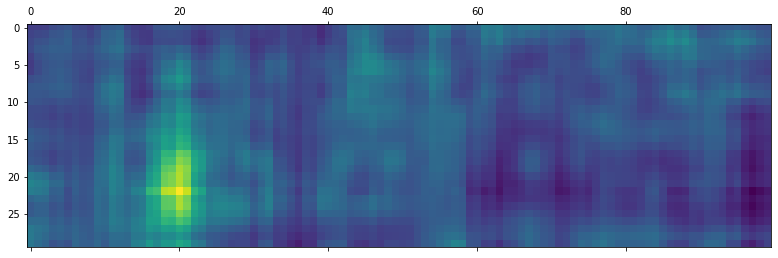

In [ ]:
plt.matshow(attn_weights.detach().cpu().numpy()[7,:,:])

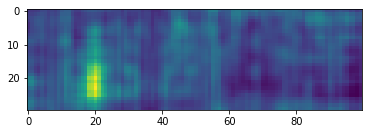

In [ ]:
plt.imshow(attn_weights.detach().cpu().numpy()[0,:,:])